Нужные импорты

In [1]:
from os import listdir, environ
#environ[KERAS_BACKEND] = "theano"
from keras.applications import InceptionV3
from os.path import join
import numpy as np
# import numpy.core.multiarray 
import cv2
from glob import glob
from sklearn.linear_model import LogisticRegression


Using TensorFlow backend.


Препроцессинг

In [2]:
def prepare_data(path, size, mode='resize', crop_num=5):
    """
    returns:
    X - np.array of size (samples_num, size, size, 3)
    Y - np.array of size (samples_num,)
    classes - list of str, indices corresponding to numbers in Y
    
    path - str - path to data, each folder in path is separate class
    size - int - desired size of images
    mode - str - 'resize' or 'random_crop'.
                 if 'resize', image is resized to desired size
                 if 'random_crop', several random crops of desired size are extracted from one image
    crop_num - int - number of crops for 'random_crop'
    """
    classes = [cl for cl in sorted(listdir(path)) if cl != '.ipynb_checkpoints']
    X = []
    Y = []
    for i,cl in enumerate(classes):
        for artist in listdir(path+"/"+cl):
            imgs = glob(join(path,cl,artist,'*.jpg'))
            for img in imgs:
                #img_np = cv2.imread(img)
                #img = img.encode("utf-8", "surrogateescape")
                try: 
                    img_np = cv2.imread(img)
                    #print(img.encode("utf-8", "surrogateescape"))
                except Exception as ex:
                    print("problems with image: ", img, ex)    
                if mode == 'resize':
                    try: 
                        img_np = cv2.resize(img_np,(size,size))
                        X.append(img_np)
                        Y.append(i)
                    except:
                        print("problems with image: ", img)
                if mode == 'random_crop':
                    if size > img_np.shape[0] or size > img_np.shape[1]:
                        raise Exception('Image {} is too small for random crop size'.format(img))
                    for _ in range(crop_num):
                        border_0 = np.random.randint(0,img_np.shape[0]-size)
                        border_1 = np.random.randint(0,img_np.shape[1]-size)
                        img_crop = img_np[border_0 : border_0 + size, border_1 : border_1 + size]
                        X.append(img_crop)
                        Y.append(i)
    X = np.array(X)
    Y = np.array(Y)
    return X,Y,classes

In [3]:
X,Y,classes = prepare_data(path='./Pandora_18k/',
                           mode='resize',
                           size = 100)

In [4]:
print(X.shape)
print(Y.shape)
print(classes)

(16943, 100, 100, 3)
(16943,)
['00_PopArt', '01_Byzantin_Iconography', '02_Early_Renaissance', '03_Northern_Renaissance', '04_High_Renaissance', '05_Baroque', '06_Rococo', '07_Romanticism', '08_Realism', '09_Impressionism', '10_Post_Impressionism', '11_Expressionism', '12_Symbolism', '13_Fauvism', '14_Cubism', '15_Surrealism', '16_AbstractArt', '17_NaiveArt']


### Нейроночка
Описание моделек можно найти тут:    
https://keras.io/applications/

Загружаем модель. `include_top=False`, потому что мы не хотим предсказывать классы, нам нужен предыдущий слой

In [5]:
model = InceptionV3(include_top=False,weights='imagenet')

Прогоняем данные через сетку

In [6]:
pred = model.predict(X)

In [7]:
print(pred.shape)

(16943, 1, 1, 2048)


Мы хотим вместо `(samples_num, хзчто,хз_что, 2048)` получить `(samples_num, хзчто)`

In [8]:
X_clf = pred.reshape(-1,pred.shape[0]).T

### Классификатор поверх фич из нейронки
Вместо логрега может быть что угодно

In [9]:
clf = LogisticRegression()

Фитим классификатор

In [10]:
X_clf = np.load('X_clf_ins3_100.npy')

In [11]:
clf.fit(X_clf,Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Так можем сделать предикт

In [12]:
Y_pred = clf.predict(X_clf)

In [13]:
np.save('X_clf_ins3_100.npy', X_clf)

In [21]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix
from scipy import stats
import matplotlib.pyplot as plt

In [56]:
scores = cross_val_score(clf, X_clf, Y, cv=4) 

In [57]:
np.save('scores_ins3_100.npy', scores)

In [58]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
stats.describe(scores)

Accuracy: 0.70 (+/- 0.47)


DescribeResult(nobs=4, minmax=(0.44880586427051311, 0.9475796930342385), mean=0.70285744861428734, variance=0.072598067898565349, skewness=-0.008554966258356958, kurtosis=-1.9780533389366617)

In [26]:
scores_f1 = cross_val_score(clf, X_clf, Y, cv=4, scoring='f1_macro')

In [27]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_f1.mean(), scores_f1.std() * 2))
stats.describe(scores_f1)

Accuracy: 0.70 (+/- 0.47)


DescribeResult(nobs=4, minmax=(0.45123136580890988, 0.94834689048599097), mean=0.70367275866012224, variance=0.073108066356280615, skewness=-0.006320334550580277, kurtosis=-1.9827642863895418)

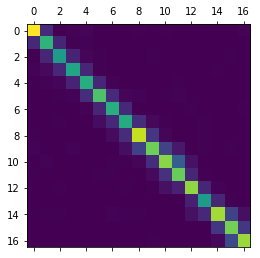

In [28]:
cross_pred = cross_val_predict(clf, X_clf, Y, cv=4)
plt.matshow(confusion_matrix(Y,cross_pred))

In [53]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.figure(figsize=(20,20))
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



Confusion matrix, without normalization
[[949 112   1   8  13   0   0   0   7   1   4   1   1   0   1   1   8]
 [107 616  99   7   8   0   1   0   0   1   3   0   3   0   0   0   2]
 [  0 101 526  93  13   6   0   0   0   4   0   0   1   0   1   4   1]
 [ 10  23 107 561 103   5   0   1   3   1   0   0   0   0   5   0   0]
 [  1   9  12  95 590 102   9   1   3   0   1   4   2   0   1   0   2]
 [  2   0   6  11 123 685 118  16   8   1   4  10   0   2   1   2   0]
 [  0   2   0   1   8 102 598 104   2   0   1   3   4   0   1   2   4]
 [  1   0   6   0   0  32 106 585 124  22   4   3   2   4   2   2   2]
 [  4   1   0   2   1   2  27 122 864 149  13   0   2   5   1   3   3]
 [  8   0   3   9   0   0   0  36 187 741 194  64   0   6   0   6   1]
 [  2  11   2   0   0   1   6   6  13 123 782 282  47   0   0   0   1]
 [  6   3   0   0   1   6   6   2   2  24 134 727 103   7   2   2   0]
 [  2   3   4   0   0   1   3   5   0   5  42  87 793 103   8   1   0]
 [  0   0   0   0   0   0   0   0   2

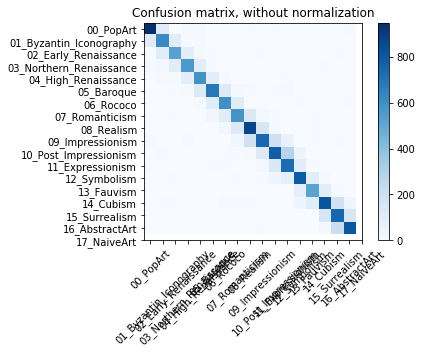

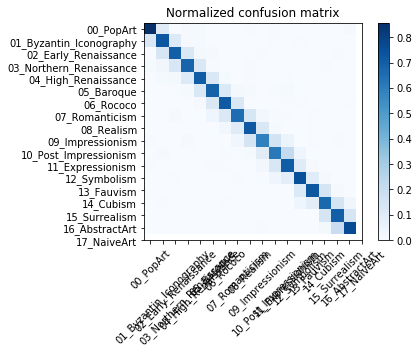

In [55]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(Y,cross_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [29]:
print(scores_f1)

[ 0.48880774  0.92630504  0.94834689  0.45123137]


In [30]:
X_clf = np.load('X_clf_ins3_100.npy')

In [31]:
X_centered = X_clf - X_clf.mean(axis=0)

In [32]:
from sklearn.manifold import TSNE, Isomap
from sklearn.datasets import load_digits, fetch_olivetti_faces
from skimage.io import *
from skimage.transform import resize



% matplotlib inline

In [33]:
tsne = TSNE(n_components=2)
styles2d =  tsne.fit_transform(X_centered)

In [34]:
def plot_2d_data(data, labels, labels_limit=20):
#     plt.figure(figsize=(5,5))
    unique_labels = np.sort(np.unique(labels))
    for i, label in enumerate(unique_labels):
        plt.figure(figsize=(5,5))
        same_objects = data[labels == label]
        plt.scatter(same_objects[:, 0], same_objects[:, 1], label=str(label))
        plt.show()
        if i + 1 >= labels_limit:
            break
    
    plt.legend(loc='best')

In [35]:
def plot_2d_data_centroids(data, labels, labels_limit=20):
    plt.figure(figsize=(10,10))
    unique_labels = np.sort(np.unique(labels))
    for i, label in enumerate(unique_labels):
#         plt.figure(figsize=(5,5))
        same_objects = data[labels == label]
        centroid = same_objects.mean(axis=0)
        plt.scatter(centroid[0], centroid[1], label=str(label))
        plt.annotate(classes[label][3:],centroid)
        if i + 1 >= labels_limit:
            break
    
#     plt.legend(loc='best')

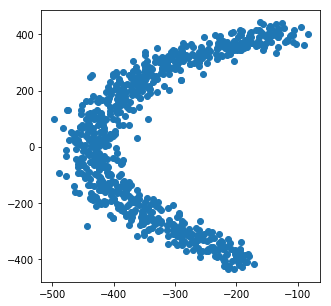

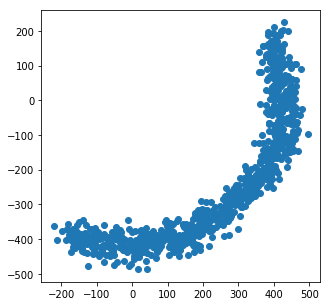

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


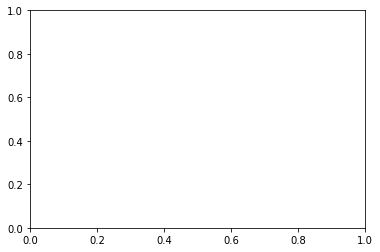

In [60]:
plot_2d_data(styles_pca[(Y == 2) | (Y == 3)], Y[(Y == 2) | (Y == 3)])

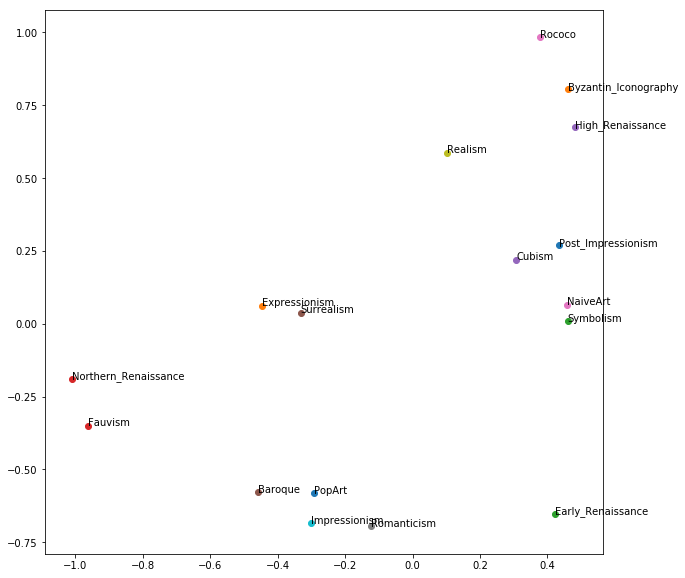

In [38]:
plot_2d_data_centroids(styles2d, Y)

'00_PopArt', '01_Byzantin_Iconography', '02_Early_Renaissance', '03_Northern_Renaissance', '04_High_Renaissance', '05_Baroque', '06_Rococo', '07_Romanticism', '08_Realism', '09_Impressionism', '10_Post_Impressionism', '11_Expressionism', '12_Symbolism', '13_Fauvism', '14_Cubism', '15_Surrealism', '16_AbstractArt', '17_NaiveArt'

Projecting 100D data to 2D


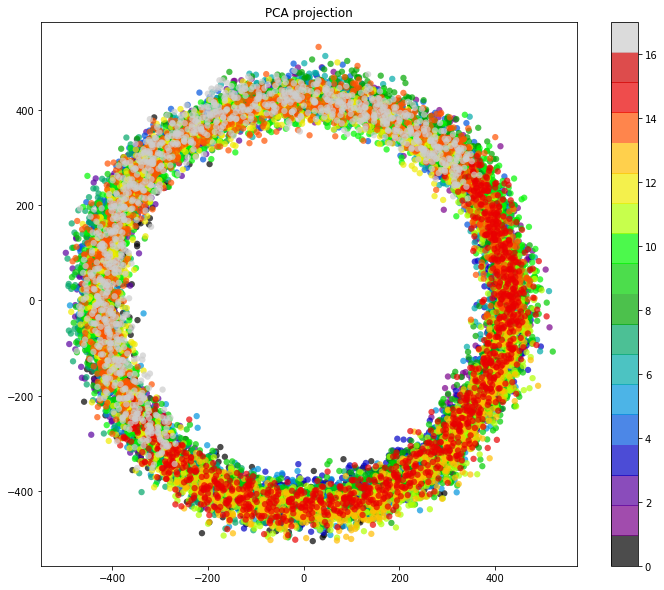

In [39]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
styles_pca = pca.fit_transform(X_centered)

print('Projecting {}D data to 2D'.format(X.shape[1]))

plt.figure(figsize=(12, 10))
plt.scatter(styles_pca[:, 0], styles_pca[:, 1], c=Y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 18))
plt.colorbar()
plt.title('PCA projection');

In [40]:
plot_2d_data_centroids(styles_pca, Y)

In [41]:
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn import decomposition

In [42]:
n_clusters = len(np.unique(Y))
clusterers = {
    "KMeans": KMeans(n_clusters=n_clusters),
#     "SpectralClustering" : SpectralClustering(n_clusters=n_clusters),
    "AgglomerativeClustering" : AgglomerativeClustering(n_clusters=n_clusters)
}



In [ ]:
for n_components in [2, 3, 5, 10, 20, 50, 100, 200, 500, 1000]:
    pca = decomposition.PCA(n_components=n_components)
    decomposed_data = pca.fit_transform(X_centered)
    for name, clusterer in clusterers.items():
        Y_pred = clusterer.fit_predict(decomposed_data)
        print('{} features\t{}\t{}'.format(n_components, name, adjusted_rand_score(Y, Y_pred)))

2 features	KMeans	0.05732858463230405
2 features	AgglomerativeClustering	0.057610802044854255
3 features	KMeans	0.058139666248313286
3 features	AgglomerativeClustering	0.05617138397044872
5 features	KMeans	0.05635635820239429
5 features	AgglomerativeClustering	0.0585237532639528
10 features	KMeans	0.05772349910973822
10 features	AgglomerativeClustering	0.0622656574882067
20 features	KMeans	0.05656834604729367
20 features	AgglomerativeClustering	0.06666312153320086
50 features	KMeans	0.056383832722965314
50 features	AgglomerativeClustering	0.06178948594640055
100 features	KMeans	0.05642699802719811
100 features	AgglomerativeClustering	0.05917933482791919
200 features	KMeans	0.05677315748662165
200 features	AgglomerativeClustering	0.057075248744687605
500 features	KMeans	0.05746905622593449
500 features	AgglomerativeClustering	0.0590511332474069
1000 features	KMeans	0.056832834386201486


In [ ]:
for name, clusterer in clusterers.items():
        Y_pred = clusterer.fit_predict(X_centered)
        print('2048 features\t{}\t{}'.format(name, adjusted_rand_score(Y, Y_pred)))

In [ ]:
X_centered.shape

In [ ]:
plt.hist(np.linalg.norm(X_centered, axis=1))